In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Project Introduction:

### Title: Solar Power Generation Forecasting Using Machine Learning

In this project, we aim to accurately forecast solar energy generation using machine learning models like XGBoost, Random Forest, and LSTM. By analyzing historical data on weather conditions (irradiation, temperature, humidity, wind speed) and PV system output, we will predict future solar production and detect anomalies that could indicate system faults. This project also generates synthetic load profiles to help optimize energy storage and grid management, enabling more efficient, reliable, and sustainable solar power usage.

The goal is to empower PV operators with better decision-making tools for energy forecasting and system optimization.

## Project Workflow

### Data Collection and Preprocessing
* **Data Acquisition:** Gather PV system generation data along with corresponding weather data (irradiation, temperature, humidity, wind velocity, etc.) from public sources, competitions, or solar power plant logs. Ensure the data aligns in terms of timestamp and region.
* **Data Cleaning:** Handle missing values, outliers, and inconsistencies in both the weather and solar generation datasets. Use interpolation techniques to fill in gaps in weather data.
* **Time-Series Resampling and Aggregation:** Aggregate data to different time scales as needed (hourly, daily) for different models while retaining the high-resolution data for accurate time-series forecasting with models like LSTM.

### Feature Engineering
* **Time-Based Features:** Create time-based features (hour of the day, day of the week, season).
* **Rolling Window Statistics:** Compute rolling window statistics (mean, variance) of weather conditions and PV generation to capture temporal dependencies and trends.
* **Feature Interactions:** Add interactions between weather features (e.g., irradiation and temperature) to enhance model accuracy.

### Exploratory Data Analysis (EDA)
* **Trend and Seasonality Detection:** Use time-series decomposition to identify trends, seasonality, and residuals in both solar generation and weather data. Visualize solar production trends over seasons, considering factors like day length and cloud cover.
* **Correlation Analysis:** Explore the correlation between weather conditions (irradiation, temperature) and PV output. High correlations will help identify key features for modeling.
* **Outlier Detection and Handling:** Detect anomalies such as PV system faults or extreme weather conditions. Handle these outliers with robust scaling techniques.

### Model Development

#### Random Forest
* **Training:** Train a Random Forest regressor on the preprocessed data.
* **Hyperparameter Tuning:** Tune hyperparameters (e.g., number of estimators, max depth) using GridSearchCV or RandomizedSearchCV.
* **Evaluation:** Evaluate model performance using metrics like RMSE, MAE, and MAPE.

#### XGBoost
* **Training:** Implement XGBoost with appropriate hyperparameters.
* **Hyperparameter Tuning:** Tune hyperparameters (e.g., learning rate, subsampling rate, max depth) using GridSearchCV or RandomizedSearchCV.
* **Evaluation:** Evaluate model performance using metrics like RMSE, MAE, and MAPE.

#### LSTM (Long Short-Term Memory)
* **Model Development:** Create an LSTM model to capture temporal dependencies.
* **Data Preparation:** Apply sliding window techniques to create input-output pairs for time-series forecasting.
* **Hyperparameter Tuning:** Tune hyperparameters (e.g., number of LSTM units, dropout rate, optimizer).
* **Evaluation:** Evaluate model performance using metrics like RMSE, MAE, and MAPE.

### Model Evaluation and Explainability
* **Evaluation Metrics:** Evaluate models using RMSE, MAE, MAPE, and forecast bias. Track performance over different seasons and time intervals.
* **Model Explainability:**
    * **SHAP or LIME:** Apply these techniques to interpret model predictions and understand the influence of weather features on PV output.
    * **Partial Dependency Plots (PDPs):** Visualize how individual features (e.g., irradiation, temperature) impact PV output predictions.
* **Error Analysis:** Analyze periods where models underperform to identify areas for improvement.

### Synthetic Load Profile Generation
* **Synthetic Profile Creation:** Use the best-performing model to generate synthetic load profiles based on future weather forecasts.
* **Validation:** Compare synthetic profiles to actual historical data during similar weather conditions.
* **Fault Detection:** Analyze deviations between predicted and actual PV outputs to detect potential system faults.

### Model Deployment and Monitoring
* **Model Deployment:** Package the final model for real-time inference.
* **Real-Time Monitoring:** Set up dashboards to track forecast accuracy and detect anomalies.
* **Anomaly Detection:** Implement alerts for significant deviations between predicted and actual PV output.

### Conclusion and Future Work
* Summarize key findings and model performance.
* Discuss potential improvements, such as incorporating real-time solar irradiance data, using reinforcement learning, or extending the model to handle hybrid energy systems.

### Data Collection and Preprocessing and EDA

In [50]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json



mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [51]:
! kaggle datasets download -d pythonafroz/solar-powe-generation-data

Dataset URL: https://www.kaggle.com/datasets/pythonafroz/solar-powe-generation-data
License(s): unknown
solar-powe-generation-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [52]:
import zipfile
zip_ref = zipfile.ZipFile('solar-powe-generation-data.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [53]:
df = pd.read_csv('/content/Solar Power Plant Data.csv')
df.head()

Date-Hour(NMT)  WindSpeed  Sunshine  AirPressure  Radiation  \
0  01.01.2017-00:00        0.6         0       1003.8       -7.4   
1  01.01.2017-01:00        1.7         0       1003.5       -7.4   
2  01.01.2017-02:00        0.6         0       1003.4       -6.7   
3  01.01.2017-03:00        2.4         0       1003.3       -7.2   
4  01.01.2017-04:00        4.0         0       1003.1       -6.3   

   AirTemperature  RelativeAirHumidity  SystemProduction  
0             0.1                   97               0.0  
1            -0.2                   98               0.0  
2            -1.2                   99               0.0  
3            -1.3                   99               0.0  
4             3.6                   67               0.0

In [54]:
df.rename(columns={'Date-Hour(NMT)':'Date'},inplace=True)
df.columns

Index(['Date', 'WindSpeed', 'Sunshine', 'AirPressure', 'Radiation',
       'AirTemperature', 'RelativeAirHumidity', 'SystemProduction'],
      dtype='object')

In [55]:
df.shape

(8760, 8)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 8760 non-null   object 
 1   WindSpeed            8760 non-null   float64
 2   Sunshine             8760 non-null   int64  
 3   AirPressure          8760 non-null   float64
 4   Radiation            8760 non-null   float64
 5   AirTemperature       8760 non-null   float64
 6   RelativeAirHumidity  8760 non-null   int64  
 7   SystemProduction     8760 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 547.6+ KB


In [57]:
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y-%H:%M')
df.head()

Date  WindSpeed  Sunshine  AirPressure  Radiation  \
0 2017-01-01 00:00:00        0.6         0       1003.8       -7.4   
1 2017-01-01 01:00:00        1.7         0       1003.5       -7.4   
2 2017-01-01 02:00:00        0.6         0       1003.4       -6.7   
3 2017-01-01 03:00:00        2.4         0       1003.3       -7.2   
4 2017-01-01 04:00:00        4.0         0       1003.1       -6.3   

   AirTemperature  RelativeAirHumidity  SystemProduction  
0             0.1                   97               0.0  
1            -0.2                   98               0.0  
2            -1.2                   99               0.0  
3            -1.3                   99               0.0  
4             3.6                   67               0.0

In [58]:
df1 = df.copy()

In [59]:
df = df.set_index('Date')
df.head()

WindSpeed  Sunshine  AirPressure  Radiation  \
Date                                                               
2017-01-01 00:00:00        0.6         0       1003.8       -7.4   
2017-01-01 01:00:00        1.7         0       1003.5       -7.4   
2017-01-01 02:00:00        0.6         0       1003.4       -6.7   
2017-01-01 03:00:00        2.4         0       1003.3       -7.2   
2017-01-01 04:00:00        4.0         0       1003.1       -6.3   

                     AirTemperature  RelativeAirHumidity  SystemProduction  
Date                                                                        
2017-01-01 00:00:00             0.1                   97               0.0  
2017-01-01 01:00:00            -0.2                   98               0.0  
2017-01-01 02:00:00            -1.2                   99               0.0  
2017-01-01 03:00:00            -1.3                   99               0.0  
2017-01-01 04:00:00             3.6                   67               0.0

In [60]:
df.isna().sum()

WindSpeed              0
Sunshine               0
AirPressure            0
Radiation              0
AirTemperature         0
RelativeAirHumidity    0
SystemProduction       0
dtype: int64

<Axes: >

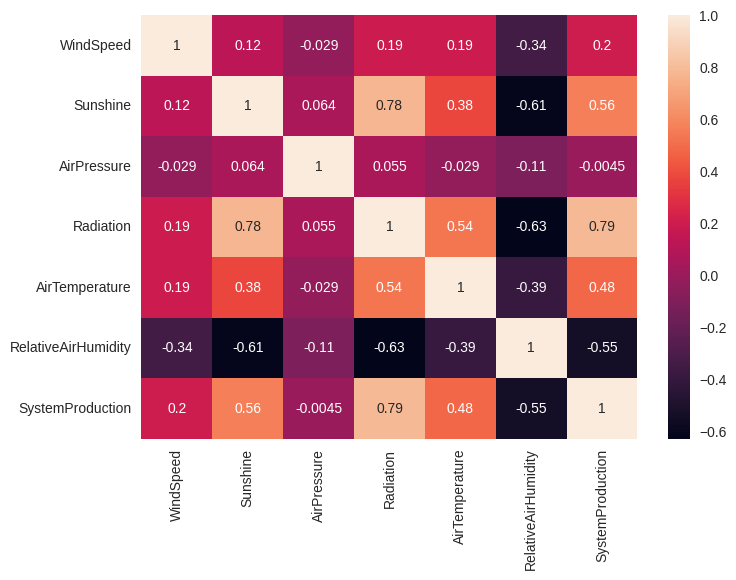

In [61]:
corr_df = df.corr()
sns.heatmap(corr_df,annot=True)

In [62]:
corr_df['SystemProduction'].sort_values(ascending=False)

SystemProduction       1.000000
Radiation              0.785717
Sunshine               0.564228
AirTemperature         0.480407
WindSpeed              0.195650
AirPressure           -0.004487
RelativeAirHumidity   -0.545252
Name: SystemProduction, dtype: float64

**We observed several correlations between key features:**

- SystemProduction and Radiation: +0.79
- Radiation and Sunshine: +0.78
- Sunshine and Relative Air: -0.61
- SystemProduction and Sunshine: +0.56
- Radiation and Relative Air: -0.63
- Air Temperature and Radiation: +0.54

*To address potential multicollinearity, we will further investigate the relationships between these features in subsequent steps, using techniques such as Variance Inflation Factor (VIF) analysis to quantify and mitigate any multicollinearity issues.*

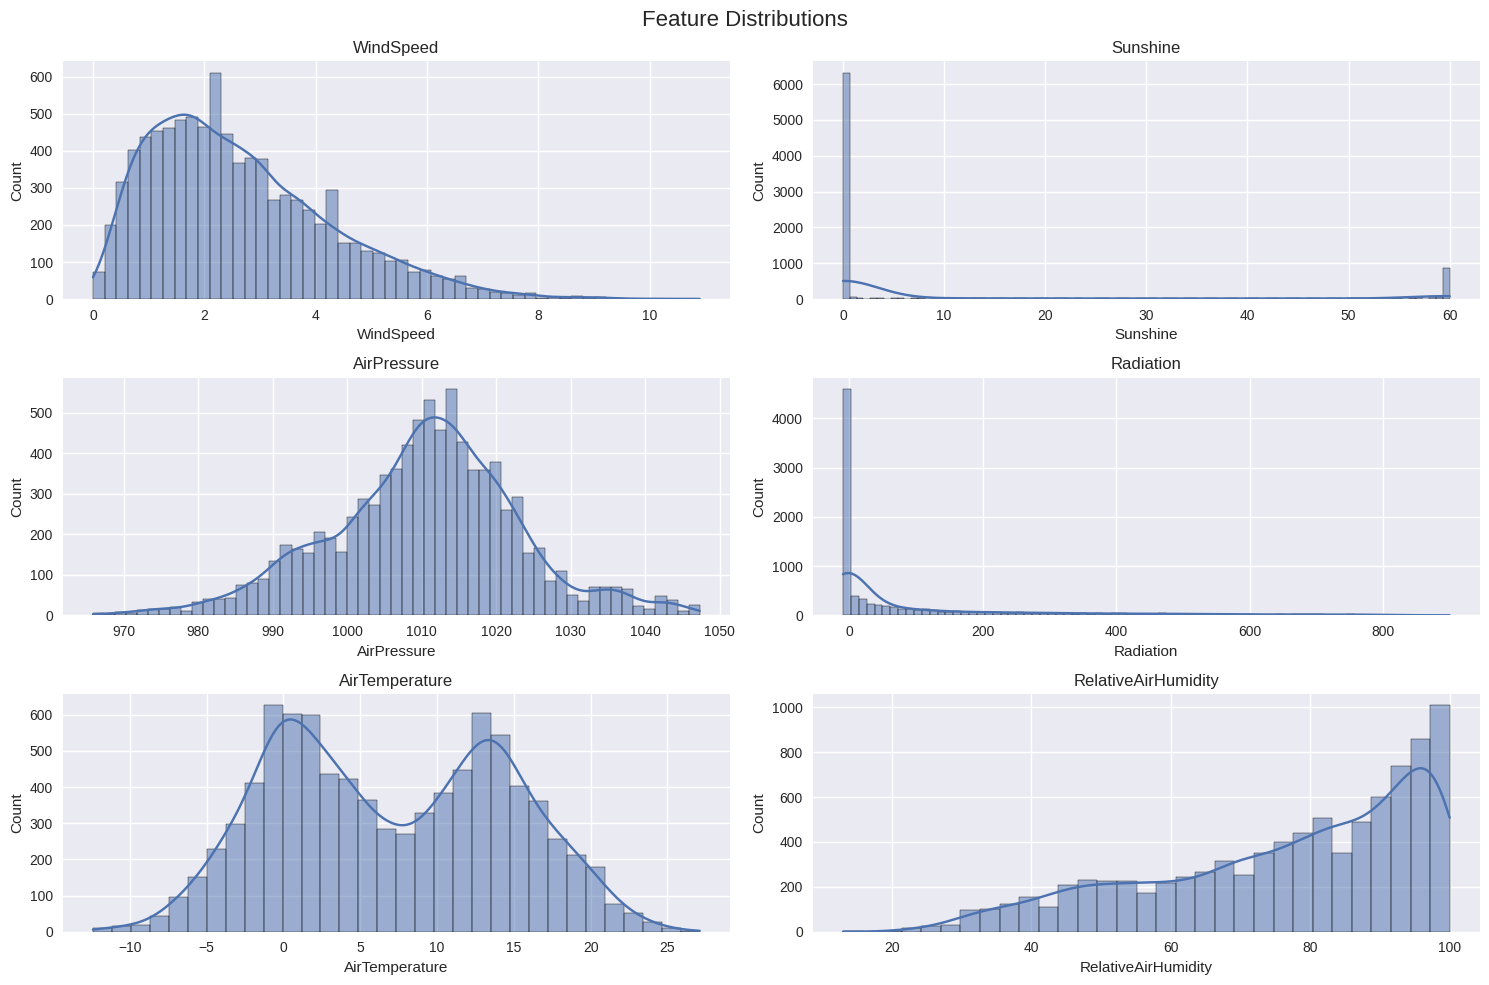

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select features to plot
features = [col for col in df.columns if col != 'SystemProduction']

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Feature Distributions', fontsize=16)

# Flatten the axes array
axes = axes.flatten()

# Plot histograms
for i, feature in enumerate(features):
    sns.histplot(data=df, x=feature, ax=axes[i], kde=True)
    axes[i].set_title(feature)

# Remove extra subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Wind Speed
* **Distribution:** Skewed to the right, with a concentration between 0 and 3 m/s.
* **Observations:** Fewer instances of higher wind speeds beyond 6 m/s.

### Sunshine
* **Distribution:** High concentration at 0, indicating frequent lack of sunshine.
* **Observations:** Only a few instances of higher sunshine values, possibly outliers.

### Air Pressure
* **Distribution:** Near-normal distribution, centered around 1015 hPa.
* **Observations:** Most values between 990 and 1030 hPa, suggesting stable atmospheric pressure.

### Radiation
* **Distribution:** Heavily right-skewed, indicating many instances of low radiation.
* **Observations:** High values of radiation are rare, typically occurring during peak sunlight hours.

### Air Temperature
* **Distribution:** Bimodal distribution with peaks around 5°C and 15°C.
* **Observations:** Most temperatures fall between -5°C and 20°C.

### Relative Humidity
* **Distribution:** Skewed towards higher humidity, with most values close to 100%.
* **Observations:** Limited instances of low humidity.

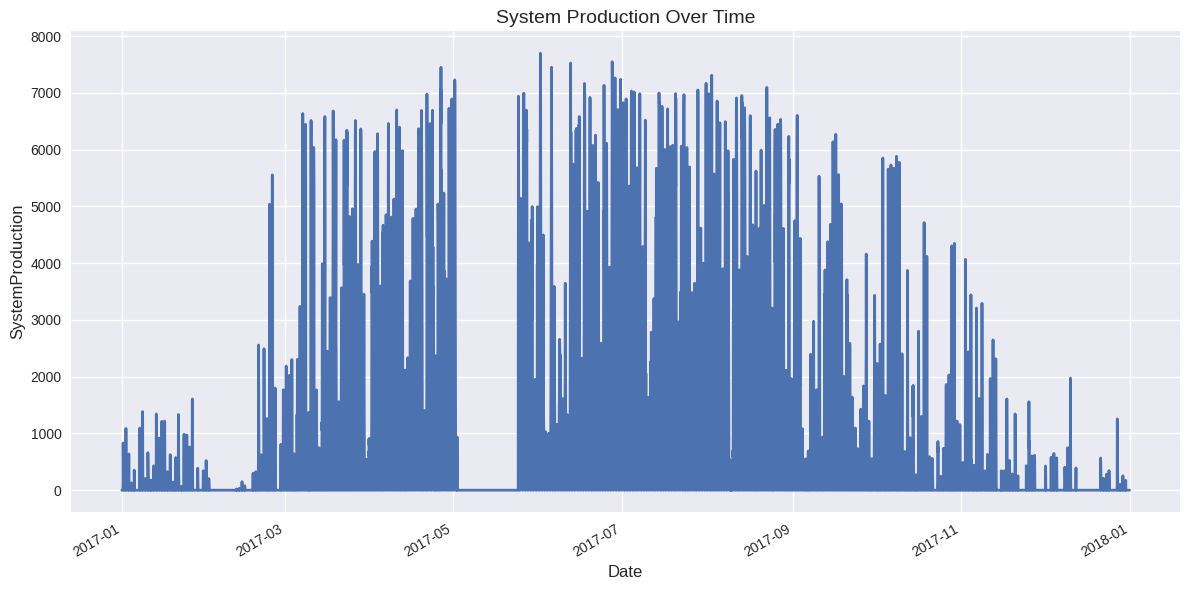

In [64]:
# Set the style for better-looking plots
plt.style.use('seaborn')

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
ax.plot(df.index, df['SystemProduction'], linewidth=2)

# Customize the plot
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('SystemProduction', fontsize=12)
ax.set_title('System Production Over Time', fontsize=14)

# Rotate and align the tick labels so they look better
fig.autofmt_xdate()

# Use tight layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

##### Using Groupby to figure hourly, daily, weekly and monthly trends

In [65]:
# Casting dates
df1['Date_day'] = df1['Date'].dt.date
# df['year'] = df['Date'].dt.year => not good, almost all belongs to same year
df1['month'] = df1['Date'].dt.month
df1['day'] = df1['Date'].dt.day
df1['hour'] = df1['Date'].dt.hour
df1.head()

Date  WindSpeed  Sunshine  AirPressure  Radiation  \
0 2017-01-01 00:00:00        0.6         0       1003.8       -7.4   
1 2017-01-01 01:00:00        1.7         0       1003.5       -7.4   
2 2017-01-01 02:00:00        0.6         0       1003.4       -6.7   
3 2017-01-01 03:00:00        2.4         0       1003.3       -7.2   
4 2017-01-01 04:00:00        4.0         0       1003.1       -6.3   

   AirTemperature  RelativeAirHumidity  SystemProduction    Date_day  month  \
0             0.1                   97               0.0  2017-01-01      1   
1            -0.2                   98               0.0  2017-01-01      1   
2            -1.2                   99               0.0  2017-01-01      1   
3            -1.3                   99               0.0  2017-01-01      1   
4             3.6                   67               0.0  2017-01-01      1   

   day  hour  
0    1     0  
1    1     1  
2    1     2  
3    1     3  
4    1     4

In [66]:
df_day = df1.iloc[:,1:9].groupby(by='Date_day').mean()
df_day.head()

WindSpeed   Sunshine  AirPressure  Radiation  AirTemperature  \
Date_day                                                                   
2017-01-01   2.262500  10.916667  1006.850000  12.675000        1.233333   
2017-01-02   1.112500  11.375000  1012.279167   9.129167       -2.737500   
2017-01-03   1.095833   5.083333   996.195833   4.766667       -2.654167   
2017-01-04   5.445833   3.000000  1005.891667   3.620833       -2.820833   
2017-01-05   1.604167  11.708333  1035.175000  10.400000      -10.008333   

            RelativeAirHumidity  SystemProduction  
Date_day                                           
2017-01-01            67.750000         74.967012  
2017-01-02            63.500000         93.375004  
2017-01-03            78.875000         63.256946  
2017-01-04            62.333333         10.350692  
2017-01-05            76.291667         24.569446

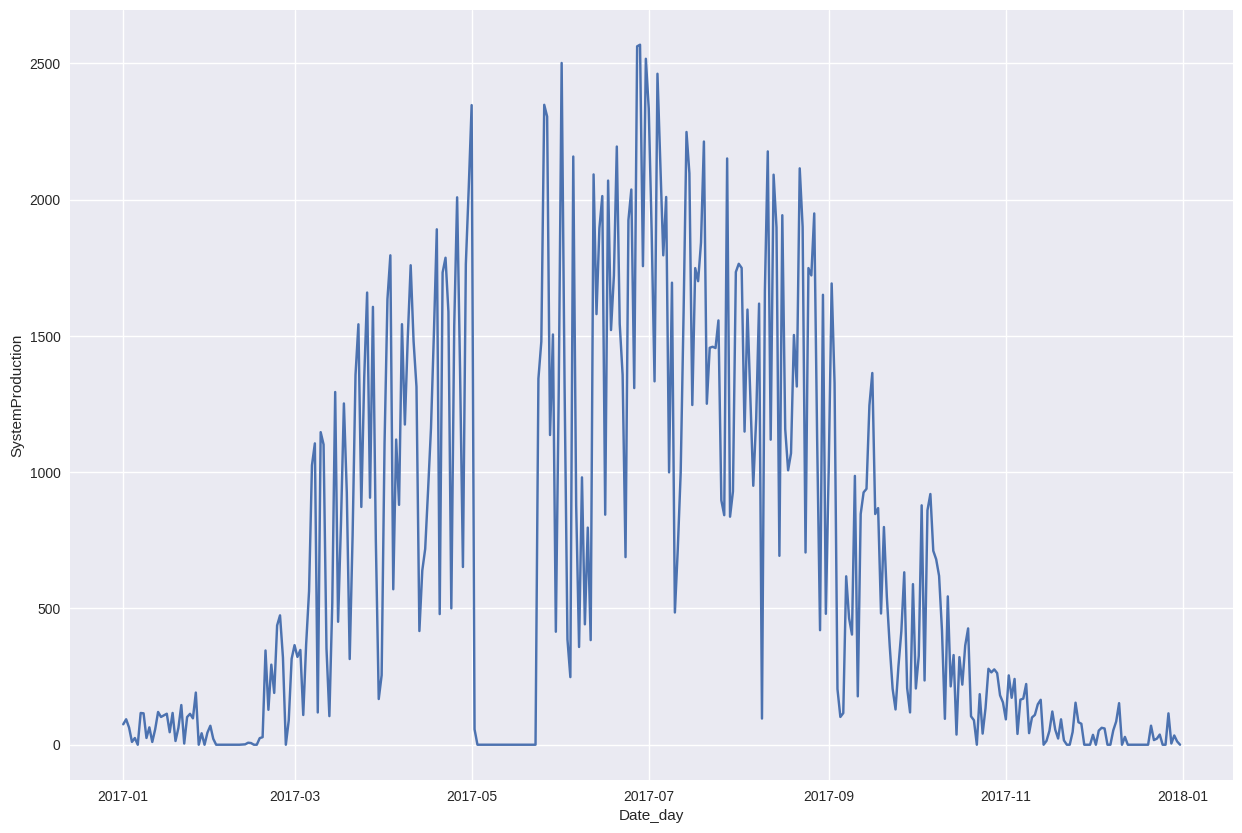

In [67]:
plt.figure(figsize = (15,10))
daily = sns.lineplot(x='Date_day', y='SystemProduction',data=df_day)

In [68]:
# Daily aggregation
df_daily = df.resample('D').mean()

# Weekly aggregation
df_weekly = df.resample('W').mean()

# Monthly aggregation
df_monthly = df.resample('M').mean()

In [69]:
import plotly.graph_objs as go
import plotly.subplots as sp

# Create subplots with shared x-axis
fig = sp.make_subplots(rows=3, cols=1, shared_xaxes=True,
                       subplot_titles=("Daily Aggregation", "Weekly Aggregation", "Monthly Aggregation"))

# Plot daily data
fig.add_trace(go.Scatter(x=df_daily.index, y=df_daily['SystemProduction'], mode='lines', name='Daily System Production'),
              row=1, col=1)

# Plot weekly data
fig.add_trace(go.Scatter(x=df_weekly.index, y=df_weekly['SystemProduction'], mode='lines', name='Weekly System Production'),
              row=2, col=1)

# Plot monthly data
fig.add_trace(go.Scatter(x=df_monthly.index, y=df_monthly['SystemProduction'], mode='lines', name='Monthly System Production'),
              row=3, col=1)

# Update layout
fig.update_layout(height=900, width=1000, title_text="System Production Aggregation (Daily, Weekly, Monthly)",
                  xaxis_title='Date', yaxis_title='System Production (MW)')

# Display the figure
fig.show()

#### Outlier Analysis

In [70]:
import plotly.express as px

# Create a box plot for each feature to detect outliers
features = ['WindSpeed', 'Sunshine', 'AirPressure', 'Radiation', 'AirTemperature', 'RelativeAirHumidity', 'SystemProduction']

for feature in features:
    fig = px.box(df, y=feature, title=f'Box Plot of {feature}')
    fig.show()

In [71]:
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
IQR = q3 - q1

print(IQR)

WindSpeed                2.20000
Sunshine                 7.00000
AirPressure             15.40000
Radiation              121.80000
AirTemperature          12.90000
RelativeAirHumidity     29.00000
SystemProduction       464.24995
dtype: float64


In [72]:
for _,f in enumerate(features):
    print(f"Percentage of Outliers for {f}:")
    print(
        round((len(df[(df[f] < (q1[_]- IQR[_]*1.5)) | (df[f] > (q3[0] + IQR[_]*1.5))]) / len(df))*100,2)
    )

Percentage of Outliers for WindSpeed:
1.46
Percentage of Outliers for Sunshine:
22.5
Percentage of Outliers for AirPressure:
100.0
Percentage of Outliers for Radiation:
19.49
Percentage of Outliers for AirTemperature:
0.55
Percentage of Outliers for RelativeAirHumidity:
89.37
Percentage of Outliers for SystemProduction:
21.31


#### VIF for checking multicollinearity

In [73]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define a function for VIF calculation to reuse later if needed
def calculate_vif(df, features):
    # Add a constant to the features (for the intercept in the regression)
    X_vif = sm.add_constant(df[features])

    # Create a DataFrame to hold VIF values
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns

    # Calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                       for i in range(X_vif.shape[1])]

    # Drop the constant row if not needed
    vif_data = vif_data[vif_data["feature"] != "const"]

    return vif_data.reset_index(drop=True)

# List of features for VIF calculation
features = ['WindSpeed', 'Sunshine', 'AirPressure', 'Radiation', 'AirTemperature', 'RelativeAirHumidity', 'SystemProduction']

# Call the function and print the VIF results
vif_results = calculate_vif(df, features)
print(vif_results)

               feature       VIF
0            WindSpeed  1.161523
1             Sunshine  2.813272
2          AirPressure  1.030335
3            Radiation  4.958600
4       AirTemperature  1.451188
5  RelativeAirHumidity  2.028122
6     SystemProduction  2.748416


- **Low VIF (< 2):** WindSpeed, AirPressure, AirTemperature, RelativeAirHumidity show no significant multicollinearity.
- **Moderate VIF (2 - 3):** Sunshine, SystemProduction have moderate correlation but are manageable.
- **High VIF (~5):** Radiation is approaching the threshold, indicating potential multicollinearity that should be monitored.

### Adding features

In [74]:
df['Seconds'] = df.index.map(pd.Timestamp.timestamp)
df.head()

WindSpeed  Sunshine  AirPressure  Radiation  \
Date                                                               
2017-01-01 00:00:00        0.6         0       1003.8       -7.4   
2017-01-01 01:00:00        1.7         0       1003.5       -7.4   
2017-01-01 02:00:00        0.6         0       1003.4       -6.7   
2017-01-01 03:00:00        2.4         0       1003.3       -7.2   
2017-01-01 04:00:00        4.0         0       1003.1       -6.3   

                     AirTemperature  RelativeAirHumidity  SystemProduction  \
Date                                                                         
2017-01-01 00:00:00             0.1                   97               0.0   
2017-01-01 01:00:00            -0.2                   98               0.0   
2017-01-01 02:00:00            -1.2                   99               0.0   
2017-01-01 03:00:00            -1.3                   99               0.0   
2017-01-01 04:00:00             3.6                   67               0.0   

                          Seconds  
Date                               
2017-01-01 00:00:00  1.483229e+09  
2017-01-01 01:00:00  1.483232e+09  
2017-01-01 02:00:00  1.483236e+09  
2017-01-01 03:00:00  1.483240e+09  
2017-01-01 04:00:00  1.483243e+09

In [75]:
day = 60*60*24
year = 365.2425 * day

df['DaySin'] = np.sin(df['Seconds'] * (2 * np.pi / day))
df['DayCos'] = np.cos(df['Seconds'] * (2 * np.pi / day))
df['YearSin'] = np.sin(df['Seconds'] * (2 * np.pi / year))
df['YearCos'] = np.cos(df['Seconds'] * (2 * np.pi / year))
df.drop(['Seconds'], axis=1, inplace=True)
df.head()

WindSpeed  Sunshine  AirPressure  Radiation  \
Date                                                               
2017-01-01 00:00:00        0.6         0       1003.8       -7.4   
2017-01-01 01:00:00        1.7         0       1003.5       -7.4   
2017-01-01 02:00:00        0.6         0       1003.4       -6.7   
2017-01-01 03:00:00        2.4         0       1003.3       -7.2   
2017-01-01 04:00:00        4.0         0       1003.1       -6.3   

                     AirTemperature  RelativeAirHumidity  SystemProduction  \
Date                                                                         
2017-01-01 00:00:00             0.1                   97               0.0   
2017-01-01 01:00:00            -0.2                   98               0.0   
2017-01-01 02:00:00            -1.2                   99               0.0   
2017-01-01 03:00:00            -1.3                   99               0.0   
2017-01-01 04:00:00             3.6                   67               0.0   

                           DaySin    DayCos   YearSin   YearCos  
Date                                                             
2017-01-01 00:00:00  2.504006e-13  1.000000  0.010364  0.999946  
2017-01-01 01:00:00  2.588190e-01  0.965926  0.011081  0.999939  
2017-01-01 02:00:00  5.000000e-01  0.866025  0.011798  0.999930  
2017-01-01 03:00:00  7.071068e-01  0.707107  0.012515  0.999922  
2017-01-01 04:00:00  8.660254e-01  0.500000  0.013231  0.999912

In [76]:
columns = [col for col in df.columns if col != 'SystemProduction'] + ['SystemProduction']
df = df[columns]

In [77]:
df.head()

WindSpeed  Sunshine  AirPressure  Radiation  \
Date                                                               
2017-01-01 00:00:00        0.6         0       1003.8       -7.4   
2017-01-01 01:00:00        1.7         0       1003.5       -7.4   
2017-01-01 02:00:00        0.6         0       1003.4       -6.7   
2017-01-01 03:00:00        2.4         0       1003.3       -7.2   
2017-01-01 04:00:00        4.0         0       1003.1       -6.3   

                     AirTemperature  RelativeAirHumidity        DaySin  \
Date                                                                     
2017-01-01 00:00:00             0.1                   97  2.504006e-13   
2017-01-01 01:00:00            -0.2                   98  2.588190e-01   
2017-01-01 02:00:00            -1.2                   99  5.000000e-01   
2017-01-01 03:00:00            -1.3                   99  7.071068e-01   
2017-01-01 04:00:00             3.6                   67  8.660254e-01   

                       DayCos   YearSin   YearCos  SystemProduction  
Date                                                                 
2017-01-01 00:00:00  1.000000  0.010364  0.999946               0.0  
2017-01-01 01:00:00  0.965926  0.011081  0.999939               0.0  
2017-01-01 02:00:00  0.866025  0.011798  0.999930               0.0  
2017-01-01 03:00:00  0.707107  0.012515  0.999922               0.0  
2017-01-01 04:00:00  0.500000  0.013231  0.999912               0.0

<Axes: >

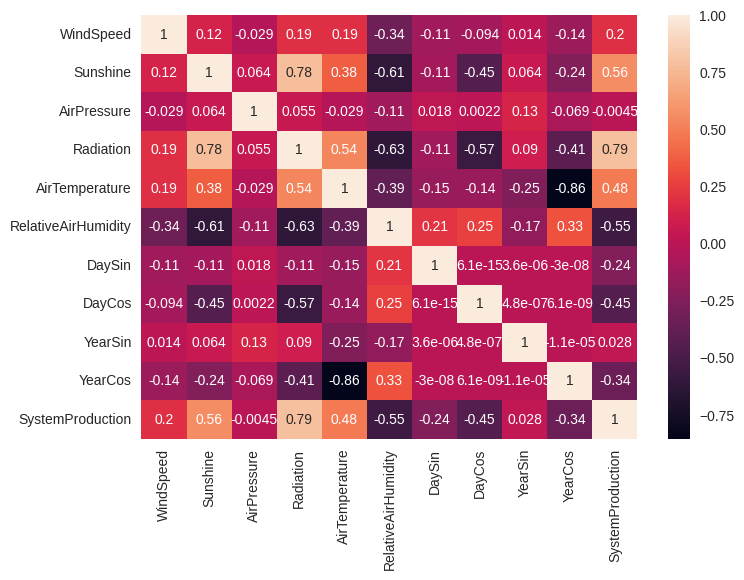

In [78]:
corr_df = df.corr()
sns.heatmap(corr_df,annot=True)

- Strong positive correlation (0.79) between Radiation and SystemProduction, indicating solar radiation is the primary driver of system output.
- Moderate positive correlation (0.56) between Sunshine and SystemProduction, reinforcing the importance of sunlight.
- Air Temperature shows a moderate positive correlation (0.48) with - SystemProduction, suggesting warmer temperatures may boost efficiency.
- RelativeAirHumidity has a moderate negative correlation (-0.55) with SystemProduction, implying humidity may reduce system efficiency.
- Strong correlations between weather variables (e.g., Radiation and Sunshine at 0.78) indicate potential multicollinearity in predictive modeling.

### Model Building

We will use following models to predict the System production.
- Linear Regression
- SVR
- Random Forest
- Decision Tree Regressor
- Gradient Booster Regressor
- LSTM


#### Train Test splitting

In [79]:
df2 = df.reset_index(drop=True)
df2.head()

WindSpeed  Sunshine  AirPressure  Radiation  AirTemperature  \
0        0.6         0       1003.8       -7.4             0.1   
1        1.7         0       1003.5       -7.4            -0.2   
2        0.6         0       1003.4       -6.7            -1.2   
3        2.4         0       1003.3       -7.2            -1.3   
4        4.0         0       1003.1       -6.3             3.6   

   RelativeAirHumidity        DaySin    DayCos   YearSin   YearCos  \
0                   97  2.504006e-13  1.000000  0.010364  0.999946   
1                   98  2.588190e-01  0.965926  0.011081  0.999939   
2                   99  5.000000e-01  0.866025  0.011798  0.999930   
3                   99  7.071068e-01  0.707107  0.012515  0.999922   
4                   67  8.660254e-01  0.500000  0.013231  0.999912   

   SystemProduction  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0

In [80]:
X = df2.drop('SystemProduction',axis=1)
y = df2['SystemProduction']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7008, 10), (1752, 10), (7008,), (1752,))

#### Scaling the features

In [81]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Model1: Linear Regression

In [82]:
# Mertic computation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

def scores(y_test, preds):
    """
    A function to calculate industry-standard regression evaluation metrics.
    Metrics: R2, RMSE, MAE, MAPE

    Parameters:
    y_test (array-like): True values of the target variable.
    preds (array-like): Predicted values of the target variable.

    Returns:
    dict: A dictionary containing the calculated metrics.
    """
    # Calculating industry-standard regression metrics
    results = {
        "R2": round(r2_score(y_test, preds), 2),
        "RMSE": round(np.sqrt(mean_squared_error(y_test, preds)), 2),
        "MAE": round(mean_absolute_error(y_test, preds), 2),
        "MAPE": round(mean_absolute_percentage_error(y_test, preds), 2)
    }

    # Print each score
    for metric, score in results.items():
        print(f"{metric} score: {score}")

    return results


In [83]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
preds_lr = model_lr.predict(X_test)

In [84]:
scores(y_test, preds_lr)

R2 score: 0.63
RMSE score: 854.08
MAE score: 489.39
MAPE score: 9.820875118418483e+17


{'R2': 0.63, 'RMSE': 854.08, 'MAE': 489.39, 'MAPE': 9.820875118418483e+17}

#### Model2: SVR

In [85]:
from sklearn.svm import SVR
model_svr = SVR()
model_svr.fit(X_train, y_train)
preds_svr = model_svr.predict(X_test)

In [86]:
scores(y_test, preds_svr)

R2 score: 0.04
RMSE score: 1381.7
MAE score: 572.34
MAPE score: 1.2557773431109069e+17


{'R2': 0.04, 'RMSE': 1381.7, 'MAE': 572.34, 'MAPE': 1.2557773431109069e+17}

#### Model3: Random Forest Regressor





In [87]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)
preds_rf = model_rf.predict(X_test)

In [88]:
scores(y_test, preds_rf)

R2 score: 0.9
RMSE score: 450.78
MAE score: 193.98
MAPE score: 8.60906892420717e+16


{'R2': 0.9, 'RMSE': 450.78, 'MAE': 193.98, 'MAPE': 8.60906892420717e+16}

#### Model4: Decision Tree Regressor

In [89]:
from sklearn.tree import DecisionTreeRegressor
model_dt = DecisionTreeRegressor()
model_dt.fit(X_train, y_train)
preds_dt = model_dt.predict(X_test)

In [90]:
scores(y_test, preds_dt)

R2 score: 0.71
RMSE score: 760.55
MAE score: 281.82
MAPE score: 6.208494101121963e+16


{'R2': 0.71, 'RMSE': 760.55, 'MAE': 281.82, 'MAPE': 6.208494101121963e+16}

#### Model5: Gradient Boost Regressor

In [91]:
from sklearn.ensemble import GradientBoostingRegressor
model_gbr = GradientBoostingRegressor()
model_gbr.fit(X_train, y_train)
preds_gbr = model_gbr.predict(X_test)

In [92]:
scores(y_test, preds_gbr)

R2 score: 0.86
RMSE score: 517.3
MAE score: 261.18
MAPE score: 2.913981284573141e+17


{'R2': 0.86, 'RMSE': 517.3, 'MAE': 261.18, 'MAPE': 2.913981284573141e+17}

#### Model6: XGBoost Regressor

In [93]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
preds_xgb = model_xgb.predict(X_test)

In [94]:
scores(y_test, preds_xgb)

R2 score: 0.88
RMSE score: 477.52
MAE score: 208.62
MAPE score: 1.3669224055918042e+17


{'R2': 0.88, 'RMSE': 477.52, 'MAE': 208.62, 'MAPE': 1.3669224055918042e+17}

Before Hyperparameter Tuning let's compare the results of all models

In [95]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def model_summary(y_test, predictions, model_names):
    """
    Parameters:
    - y_test: True labels for the test data.
    - predictions: Dictionary with model names as keys and their predictions as values.
    - model_names: List of model names corresponding to the predictions.
    """
    # Initialize a list to store model performance metrics
    metrics = []

    # Calculate and store the performance metrics for each model
    for name in model_names:
        if name in predictions:
            y_pred = predictions[name]

            # Calculate performance metrics
            r2 = np.round(r2_score(y_test, y_pred), 2)
            mse = np.round(mean_squared_error(y_test, y_pred), 2)
            rmse = np.round(np.sqrt(mse), 2)
            mae = np.round(mean_absolute_error(y_test, y_pred), 2)

            # Append the metrics to the list
            metrics.append([name, r2, mse, rmse, mae])
        else:
            print(f"Warning: Predictions for model '{name}' not found.")

    # Convert the list to a pandas DataFrame for a cleaner display
    df_metrics = pd.DataFrame(metrics, columns=["Model", "R²", "MSE", "RMSE", "MAE"])

    # Print a nicely formatted summary table
    print("\nModel Performance Summary:")
    print("--------------------------")
    print("{:<20} {:<8} {:<8} {:<8} {:<8}".format("Model", "R²", "MSE", "RMSE", "MAE"))
    print("-" * 65)

    for index, row in df_metrics.iterrows():
        print("{:<20} {:<8.2f} {:<8.2f} {:<8.2f} {:<8.2f}".format(row['Model'], row['R²'], row['MSE'], row['RMSE'], row['MAE']))


In [96]:
predictions = {
    'Linear Regression': model_lr.predict(X_test),
    'Decision Tree': model_dt.predict(X_test),
    'Random Forest': model_rf.predict(X_test),
    'SVR': model_svr.predict(X_test),
    'XGBClassifier': model_xgb.predict(X_test),
    'Gradient Boosting': model_gbr.predict(X_test)
}

model_names = list(predictions.keys())

model_summary(y_test, predictions, model_names)


Model Performance Summary:
--------------------------
Model                R²       MSE      RMSE     MAE     
-----------------------------------------------------------------
Linear Regression    0.63     729452.14 854.08   489.39  
Decision Tree        0.71     578439.17 760.55   281.82  
Random Forest        0.90     203203.69 450.78   193.98  
SVR                  0.04     1909102.68 1381.70  572.34  
XGBClassifier        0.88     228028.54 477.52   208.62  
Gradient Boosting    0.86     267603.86 517.30   261.18  


#### Best Performing Models (Without Time Dimensions)

* **Random Forest (0.90):** Demonstrates excellent predictive capability.
* **Gradient Boosting (0.86):** Shows solid performance, closely following Random Forest.
* **XGBoost (0.88):** Also a strong contender, providing competitive results alongside Gradient Boosting.

**Conclusion:**

After removing the time dimensions, Random Forest remains the standout model, while Gradient Boosting and XGBoost maintain their robustness.

**Next Steps:**

* Focus on hyperparameter tuning for Random Forest, Gradient Boosting, and XGBoost to enhance their performance further.

##### Hyperparameter Tuning: Random Forest Regressor

In [100]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Defining the hyperparameter search space
param_dist = {
    'n_estimators': randint(100, 501),
    'max_depth': randint(10, 21),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1,6),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
}

# Creating the Randomized Search Object
tuned_rf = RandomizedSearchCV(estimator = model_rf, param_distributions = param_dist, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')


# Fitting the model
tuned_rf.fit(X_train, y_train)

# Getting the best model
best_model_rf = tuned_rf.best_estimator_

# Evaluating the best model on the test set
y_pred_rf = best_model_rf.predict(X_test)
r2 = r2_score(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)

print("R2 Score:", r2)
print("MSE:", mse)
print("RMSE:", rmse)



Fitting 3 folds for each of 100 candidates, totalling 300 fits
R2 Score: 0.9057135828196002
MSE: 186541.16650693203
RMSE: 431.9041172609171


In [101]:
tuned_rf.best_params_

{'bootstrap': False,
 'max_depth': 16,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 275}

##### Hyperparameter Tuning: Gradient Boost Regressor

In [102]:
# Defining the Hyperparameter search space
param_dist = {'n_estimators': randint(100, 501),
    'max_depth': randint(3, 11),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'learning_rate': uniform(0.01, 0.31),
    'max_features': ['auto', 'sqrt', 'log2'],

}

# Creating the Randomized Search object
tuned_gbr = RandomizedSearchCV(estimator = model_gbr, param_distributions = param_dist, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fitting the Randomized Search model
tuned_gbr.fit(X_train, y_train)

# Getting the best model
best_model_gbr = tuned_gbr.best_estimator_

# Evaluating the best model on the test set
y_pred = best_model_gbr.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("R2 Score:", r2)
print("MSE:", mse)
print("RMSE:", rmse)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
R2 Score: 0.8984762678729744
MSE: 200859.84795538036
RMSE: 448.1739036974156


##### Hyperparameter Tuning: XGBoost Regressor

In [103]:
# Defining the hyperparameter search space
param_dist = {
    'n_estimators': randint(100, 501),
    'max_depth': randint(3, 11),
    'learning_rate': uniform(0.01, 0.31),
    'min_child_weight': randint(1, 11),
    'gamma': uniform(0, 1),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Creating the randomized search CV
tuned_XG = RandomizedSearchCV(estimator=model_xgb, param_distributions=param_dist, n_iter=100, scoring='neg_mean_squared_error', cv=10, verbose=2, random_state=42, n_jobs=-1)

# Fitting the model
tuned_XG.fit(X_train, y_train)

# Getting the best model
best_model_xgb = tuned_XG.best_estimator_

# Evaluating the best model on the test set
y_pred = best_model_xgb.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("R2 Score:", r2)
print("MSE:", mse)
print("RMSE:", rmse)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
R2 Score: 0.9030689936033753
MSE: 191773.35977589854
RMSE: 437.91935305019183


Best Performing Model: Random Forest Regressor

Based on the results provided, the Random Forest Regressor appears to be the best performing model:

* **R-squared score:** 0.9057 (highest among all models)
* **Mean Squared Error (MSE):** 186,541.17 (lowest among all models)
* **Root Mean Squared Error (RMSE):** 431.90 (lowest among all models)

**Conclusion:**

The Random Forest Regressor would be the recommended choice for this problem due to its superior predictive performance.

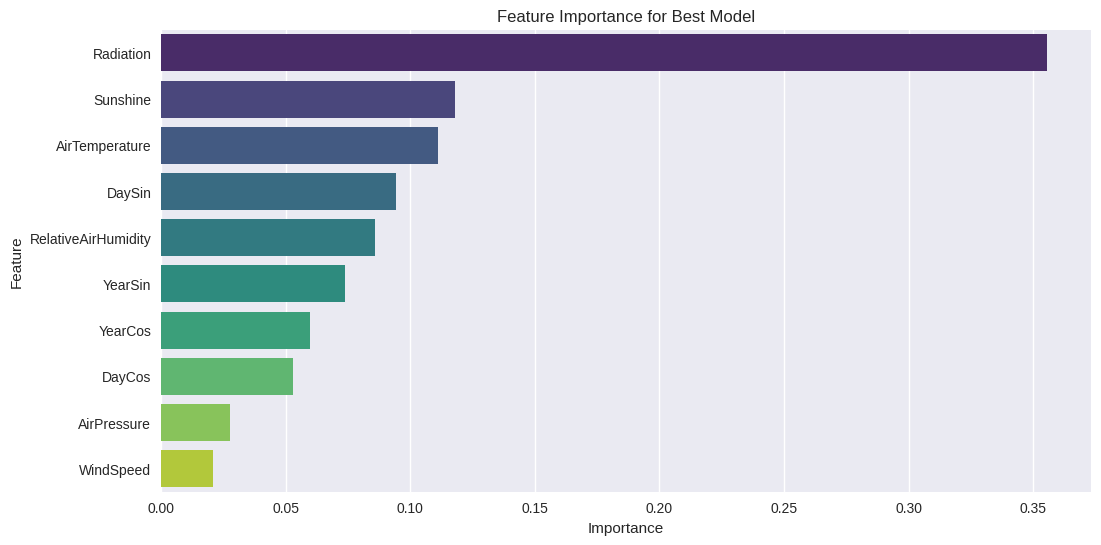

In [110]:
featue_importance = best_model_rf.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': featue_importance})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance for Best Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()